# KITTI Data Visualization
This is a notebook to visualize KITTI data

In [3]:
# Initialization
%load_ext autoreload
%autoreload 2

# Basic imports for file manipulation
import sys
import os
import time
import copy
import pickle
import glob
# Matrix manipulation library
import numpy as np
# Pytorch Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms.functional as F
import torch.utils.data


# Standard python random library
import random

# Computer vision libraries for image manipulation
import cv2 as cv 
from PIL import Image
import seaborn as sns

# The following are to do with interactive notebook code
%matplotlib inline 
import matplotlib
from matplotlib import pyplot as plt # this lets you draw inline pictures in the notebooks
import pylab # this allows you to control figure size 
pylab.rcParams['figure.figsize'] = (10.0, 8.0) # this controls figure size in the notebook

print(f"OpenCV Version: {cv.__version__}")
plt.ion()   # interactive mode

dtype = torch.float
ltype = torch.long
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

print('Torch using device:', device)

OpenCV Version: 4.2.0
Torch using device: cuda:0


In [4]:
def insert_to_path_if_necessary(path):
    if path not in sys.path:
        sys.path.insert(0, os.path.abspath(path))
        print("Updated Python Path")

In [5]:
kitti_root_path = os.path.abspath('/cs6945share/kitti_datasets')
kitti_depth_data_path = os.path.join(kitti_root_path, 'depth')
kitti_raw_data_path = os.path.join(kitti_root_path, 'raw')
kitti_depthflattened_data_path = os.path.join(kitti_root_path, 'depth_flattened')

print("KITTI root path: {0}\nKITTI depth data path: {1}\nKITTI raw data path: {2}\nKITTI depth flattened data path: {3}".format(kitti_root_path, kitti_depth_data_path, kitti_raw_data_path, kitti_depthflattened_data_path))

KITTI root path: /cs6945share/kitti_datasets
KITTI depth data path: /cs6945share/kitti_datasets/depth
KITTI raw data path: /cs6945share/kitti_datasets/raw
KITTI depth flattened data path: /cs6945share/kitti_datasets/depth_flattened


# KITTI Data Usage Points
## Difference between "raw" KITTI dataset and "depth" KITTI dataset
- The difference between this and the raw data is (From: https://github.com/ialhashim/DenseDepth/issues/51#issuecomment-524822202):
    - KITTI raw refers to the ground truth, which is created by simply projecting one 360° LIDAR scan into the camera image. It is usually created on the fly based on the LIDAR bin files.
        - http://www.cvlibs.net/datasets/kitti/raw_data.php
        - https://github.com/nianticlabs/monodepth2/blob/master/datasets/kitti_dataset.py#L65 
    - KITTI depth refers to a refined ground truth, which was created by Uhrig et. al through aggregation and automatic filtering of KITTI raw. It is only available for cam2 and cam3 and is stored as png.
        - http://www.cvlibs.net/datasets/kitti/eval_depth.php?benchmark=depth_prediction 
        - http://www.cvlibs.net/publications/Uhrig2017THREEDV.pdf 
            - Mentions: “we use the image plane of the KITTI reference camera for all our experiments” 


## Depth map format
Kitti depth values contained in the depth dataset .png files are in meters (can be converted to as mentioned below) and from "the image plane of the KITTI reference camera for all our experiments" (as per http://www.cvlibs.net/publications/Uhrig2017THREEDV.pdf)

From the depth dev kit readme:

Depth maps (annotated and raw Velodyne scans) are saved as uint16 PNG images,
which can be opened with either MATLAB, libpng++ or the latest version of
Python's pillow (from PIL import Image). A 0 value indicates an invalid pixel
(ie, no ground truth exists, or the estimation algorithm didn't produce an
estimate for that pixel). Otherwise, the **depth for a pixel can be computed
in meters** by converting the uint16 value to float and dividing it by 256.0:

disp(u,v)  = ((float)I(u,v))/256.0;

valid(u,v) = I(u,v)>0;

In [6]:
# From devkit_depth from depth kitti data download
def depth_read(filename):
    # loads depth map D from png file
    # and returns it as a numpy array,
    # for details see readme.txt

    depth_png = np.array(Image.open(filename), dtype=int)
    # make sure we have a proper 16bit depth map here.. not 8bit!
    assert(np.max(depth_png) > 255)

    depth = depth_png.astype(np.float) / 256.
    depth[depth_png == 0] = -1.
    return depth

def depthmap_viz(depthmap_filepath, ax, should_print_size=False):
    d_map = depth_read(depthmap_filepath)
    if should_print_size: 
        print('depth map size: {0}'.format(d_map.shape))
    sns.heatmap(d_map, cmap=sns.color_palette("Spectral_r", as_cmap=True), square=True, ax=ax)
    ax.set_yticks([],[])
    ax.set_xticks([],[])

def depthmap_filepaths(depth_dir_filepath, total_num_viz=3, imgs_per_viz=30):
    num_viz = 0
    filepaths_list = []
    for i, filename in enumerate(sorted(glob.glob(os.path.join(depth_dir_filepath, "*.png")))):
        if num_viz == total_num_viz:
            break
        if (i % imgs_per_viz) != 0:
            continue
        filepaths_list.append(os.path.abspath(filename))
        num_viz +=1
    return filepaths_list



/cs6945share/kitti_datasets/depth/data_depth_velodyne/train/2011_09_26_drive_0009_sync/proj_depth/velodyne_raw/image_02/0000000005.png
depth map size: (375, 1242)


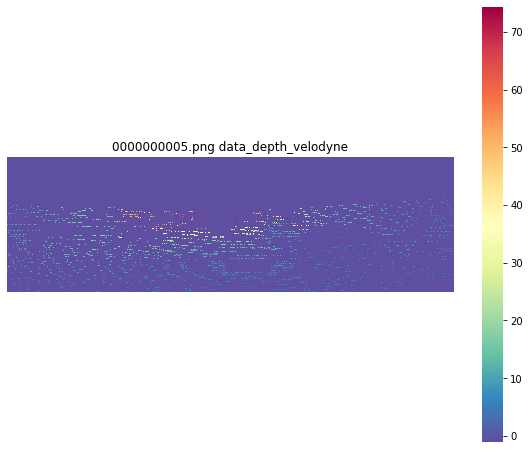

/cs6945share/kitti_datasets/depth/data_depth_annotated/train/2011_09_26_drive_0009_sync/proj_depth/groundtruth/image_02/0000000005.png
depth map size: (375, 1242)


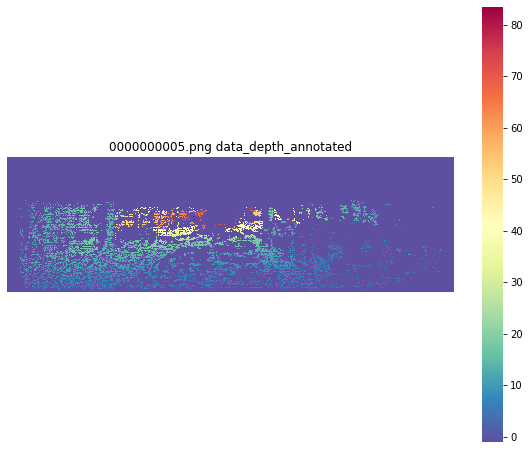

/cs6945share/kitti_datasets/depth/data_depth_velodyne/train/2011_09_26_drive_0009_sync/proj_depth/velodyne_raw/image_02/0000000035.png
depth map size: (375, 1242)


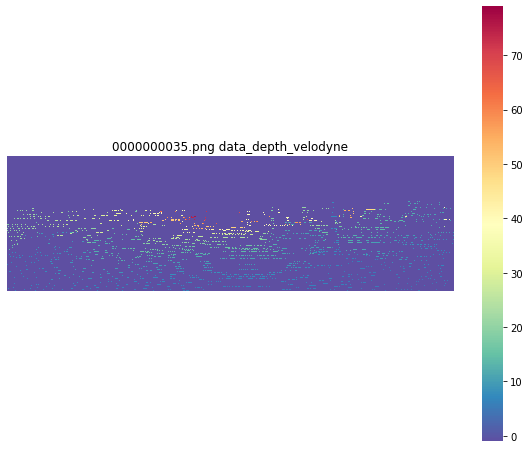

/cs6945share/kitti_datasets/depth/data_depth_annotated/train/2011_09_26_drive_0009_sync/proj_depth/groundtruth/image_02/0000000035.png
depth map size: (375, 1242)


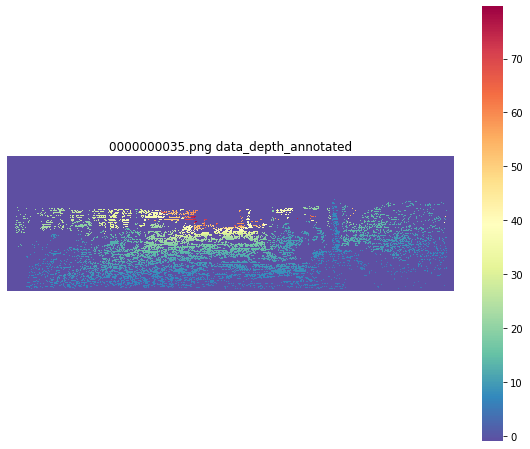

/cs6945share/kitti_datasets/depth/data_depth_velodyne/train/2011_09_26_drive_0009_sync/proj_depth/velodyne_raw/image_02/0000000065.png
depth map size: (375, 1242)


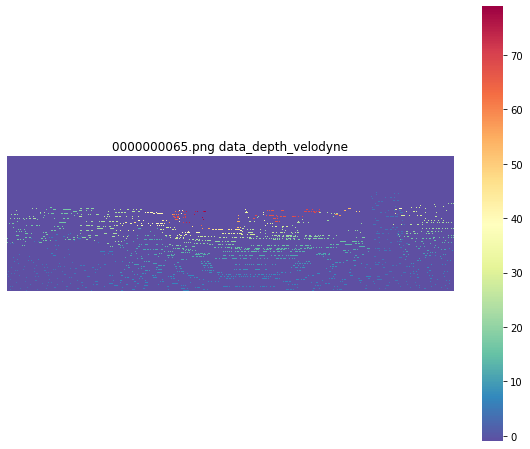

/cs6945share/kitti_datasets/depth/data_depth_annotated/train/2011_09_26_drive_0009_sync/proj_depth/groundtruth/image_02/0000000065.png
depth map size: (375, 1242)


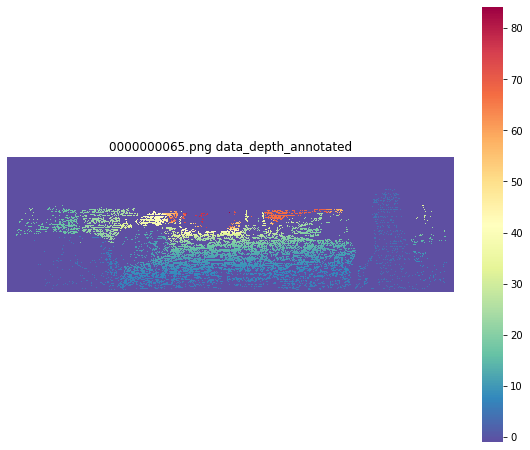

In [7]:
raw_filepaths = depthmap_filepaths(os.path.join(kitti_depth_data_path, 'data_depth_velodyne/train/2011_09_26_drive_0009_sync/proj_depth/velodyne_raw/image_02'))
depth_filepaths = depthmap_filepaths(os.path.join(kitti_depth_data_path, 'data_depth_annotated/train/2011_09_26_drive_0009_sync/proj_depth/groundtruth/image_02'))
depth_filepaths_basenames_dict = {os.path.basename(filepath):i for i, filepath in enumerate(depth_filepaths)}
# "depth" is the "improved" depth map mentioned in paper
for raw_filepath in raw_filepaths:
    print(raw_filepath)
    basename = os.path.basename(raw_filepath)
    fig, ax = plt.subplots(1,1)
    ax.set_title('{0} data_depth_velodyne'.format(basename))
    depthmap_viz(raw_filepath, ax, should_print_size=True)
    plt.show()
    if basename in depth_filepaths_basenames_dict:
        depth_filepath = depth_filepaths[depth_filepaths_basenames_dict[basename]]
        print(depth_filepath)
        fig, ax = plt.subplots(1,1)
        ax.set_title('{0} data_depth_annotated'.format(basename))
        depthmap_viz(depth_filepath, ax, should_print_size=True)
        plt.show()
    else:
        print('A corresponding {0} was not sampled out of data_depth_annotated'.format(basename))    
        


raw: /cs6945share/kitti_datasets/depth_flattened/raw_images/_2011_09_26_drive_0001_sync_image_02_0000000005.png
depth: /cs6945share/kitti_datasets/depth_flattened/depth_images/_2011_09_26_drive_0001_sync_image_02_0000000005.png
raw image size: (375, 1242, 3)
depth map size: (375, 1242)


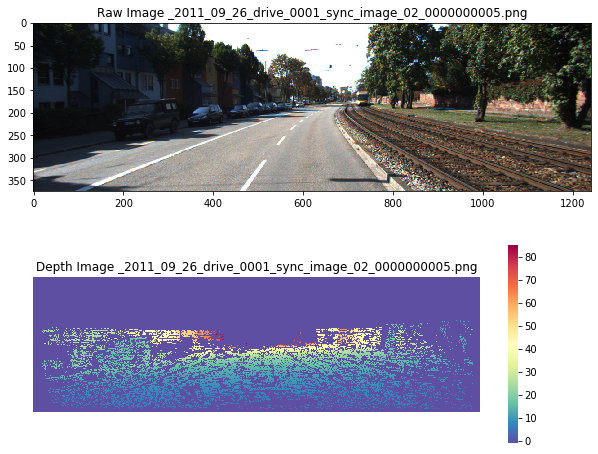

raw: /cs6945share/kitti_datasets/depth_flattened/raw_images/_2011_09_26_drive_0018_sync_image_02_0000000107.png
depth: /cs6945share/kitti_datasets/depth_flattened/depth_images/_2011_09_26_drive_0018_sync_image_02_0000000107.png
raw image size: (375, 1242, 3)
depth map size: (375, 1242)


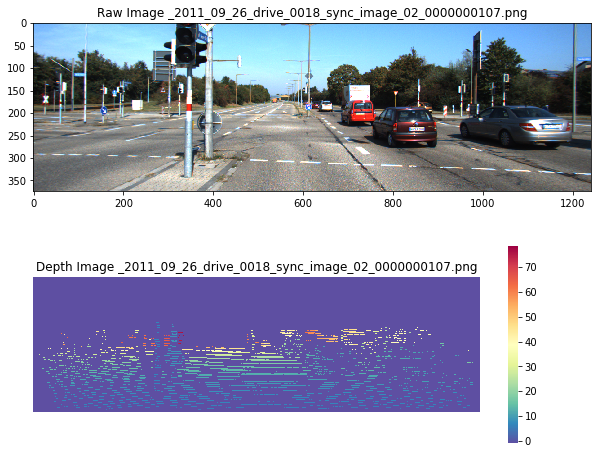

raw: /cs6945share/kitti_datasets/depth_flattened/raw_images/_2011_09_26_drive_0027_sync_image_02_0000000065.png
depth: /cs6945share/kitti_datasets/depth_flattened/depth_images/_2011_09_26_drive_0027_sync_image_02_0000000065.png
raw image size: (375, 1242, 3)
depth map size: (375, 1242)


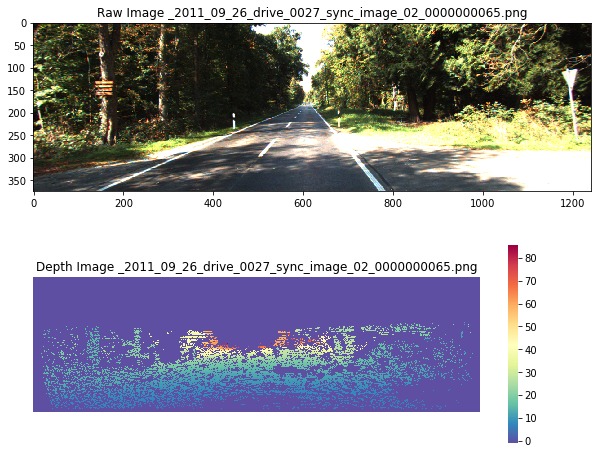

raw: /cs6945share/kitti_datasets/depth_flattened/raw_images/_2011_09_26_drive_0039_sync_image_02_0000000027.png
depth: /cs6945share/kitti_datasets/depth_flattened/depth_images/_2011_09_26_drive_0039_sync_image_02_0000000027.png
raw image size: (375, 1242, 3)
depth map size: (375, 1242)


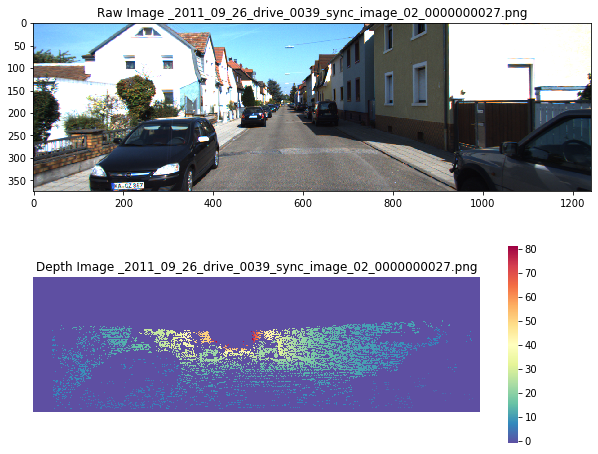

raw: /cs6945share/kitti_datasets/depth_flattened/raw_images/_2011_09_26_drive_0057_sync_image_03_0000000092.png
depth: /cs6945share/kitti_datasets/depth_flattened/depth_images/_2011_09_26_drive_0057_sync_image_03_0000000092.png
raw image size: (375, 1242, 3)
depth map size: (375, 1242)


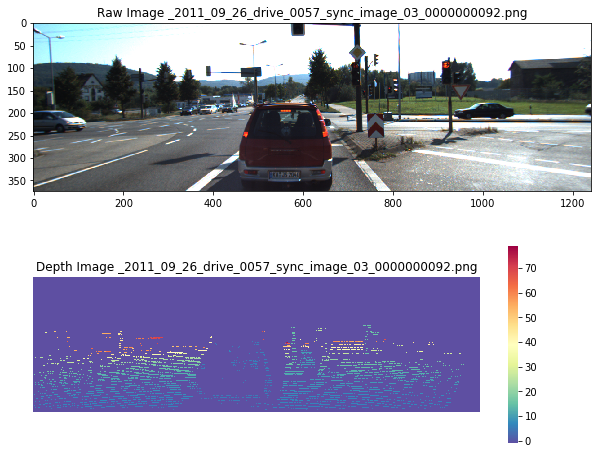

In [8]:
depthflattened_filepaths = depthmap_filepaths(os.path.join(kitti_depthflattened_data_path,'depth_images'), total_num_viz=5, imgs_per_viz=3000)
rawflattened_images_filepaths = depthmap_filepaths(os.path.join(kitti_depthflattened_data_path,'raw_images'), total_num_viz=5, imgs_per_viz=3000)

for raw_image_filepath, depth_filepath in zip(rawflattened_images_filepaths, depthflattened_filepaths):
    print('raw: {0}\ndepth: {1}'.format(raw_image_filepath, depth_filepath))
    raw_image = plt.imread(raw_image_filepath)
    print('raw image size: {0}'.format(raw_image.shape))
    basename = os.path.basename(raw_image_filepath)
    fig, (ax1, ax2) = plt.subplots(2,1)
    ax1.set_title('Raw Image {0}'.format(basename))
    ax1.imshow(raw_image)
    ax2.set_title('Depth Image {0}'.format(basename))
    depthmap_viz(depth_filepath, ax2, should_print_size=True)
    plt.show()

raw: /cs6945share/kitti_datasets/depth/data_depth_selection/test_depth_completion_anonymous/image/0000000000.png
depth: /cs6945share/kitti_datasets/depth/data_depth_selection/test_depth_completion_anonymous/velodyne_raw/0000000000.png
raw image size: (375, 1242, 3)
depth map size: (352, 1216)


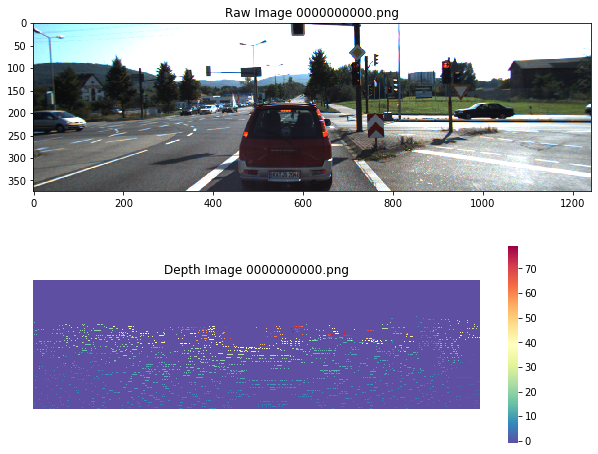

raw: /cs6945share/kitti_datasets/depth/data_depth_selection/test_depth_completion_anonymous/image/0000000030.png
depth: /cs6945share/kitti_datasets/depth/data_depth_selection/test_depth_completion_anonymous/velodyne_raw/0000000030.png
raw image size: (375, 1242, 3)
depth map size: (352, 1216)


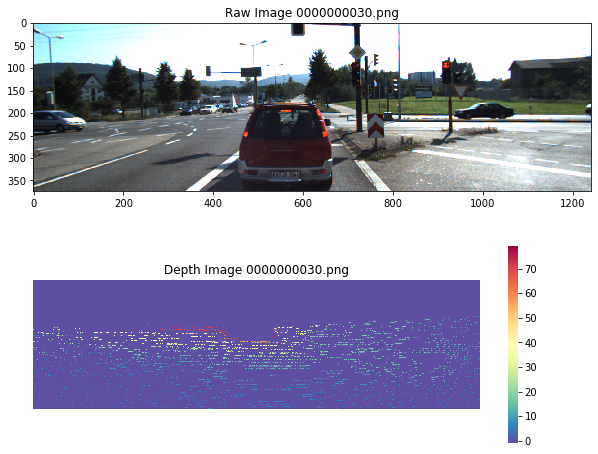

raw: /cs6945share/kitti_datasets/depth/data_depth_selection/test_depth_completion_anonymous/image/0000000060.png
depth: /cs6945share/kitti_datasets/depth/data_depth_selection/test_depth_completion_anonymous/velodyne_raw/0000000060.png
raw image size: (375, 1242, 3)
depth map size: (352, 1216)


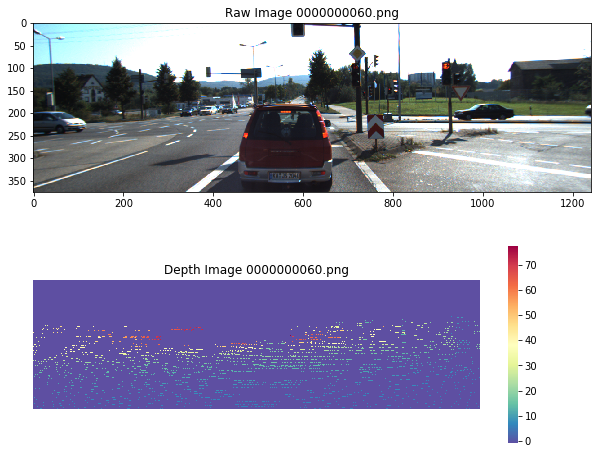

In [9]:
rawtest_filepaths = depthmap_filepaths(os.path.join(kitti_depth_data_path, '/cs6945share/kitti_datasets/depth/data_depth_selection/test_depth_completion_anonymous/image/'))
depthtest_filepaths = depthmap_filepaths(os.path.join(kitti_depth_data_path, '/cs6945share/kitti_datasets/depth/data_depth_selection/test_depth_completion_anonymous/velodyne_raw/'))
for raw_filepath, depth_filepath in zip(rawtest_filepaths, depthtest_filepaths):
    print('raw: {0}\ndepth: {1}'.format(raw_filepath, depth_filepath))
    print('raw image size: {0}'.format(raw_image.shape))
    basename = os.path.basename(raw_filepath)
    fig, (ax1, ax2) = plt.subplots(2,1)
    ax1.set_title('Raw Image {0}'.format(basename))
    raw_image = plt.imread(raw_image_filepath)
    ax1.imshow(raw_image)
    ax2.set_title('Depth Image {0}'.format(basename))
    depthmap_viz(depth_filepath, ax2, should_print_size=True)
    plt.show()




# Depth Completion
**NOTE**: This task is not necessarily what will be used for crack size estimation (loss functions for single shot monocular depth often use sparse data_, but may be useful in the future for Blyncsy in going from raw collected Lidar to a full per-pixel depth map. 


Using PENet: Precise and Efficient Depth Completion
- https://arxiv.org/abs/2103.00783
- https://github.com/JUGGHM/PENet_ICRA2021

In [6]:
os.chdir('PENet_ICRA2021')
try:
    pe = torch.load('pe.pth.tar')
finally:
    os.chdir('..')

In [7]:
pe_model = pe['model']


In [9]:
pe_net_src_root = 'PENet_ICRA2021'
insert_to_path_if_necessary(pe_net_src_root)

Updated Python Path


**WARNING the command below may take a while to run**

In [40]:
os.chdir('PENet_ICRA2021')
try:
    !python main.py -b 1 -n pe --evaluate pe.pth.tar --data-folder /cs6945share/kitti_datasets/depth/ --data-folder-save /cs6945share/kitti_datasets/depth/data_pe_completed_depth --data-folder-rgb /cs6945share/kitti_datasets/raw/ --test
finally:
    os.chdir('..')

Namespace(batch_size=1, convolutional_layer_encoding='xyz', cpu=False, criterion='l2', data_folder='/cs6945share/kitti_datasets/depth/', data_folder_rgb='/cs6945share/kitti_datasets/raw/', data_folder_save='/cs6945share/kitti_datasets/depth/data_pe_completed_depth', dilation_rate=2, epochs=100, evaluate='pe.pth.tar', freeze_backbone=False, input='rgbd', jitter=0.1, lr=0.001, network_model='pe', not_random_crop=False, print_freq=10, random_crop_height=320, random_crop_width=1216, rank_metric='rmse', result='../results', resume='', start_epoch=0, start_epoch_bias=0, test=True, use_d=True, use_g=True, use_rgb=True, val='select', val_h=352, val_w=1216, weight_decay=1e-06, workers=4)
=> using 'cuda' for computation.
=> loading checkpoint 'pe.pth.tar' ... Completed.
=> creating model and optimizer ... => checkpoint state loaded.
=> creating source code backup ...
=> finished creating source code backup.
=> logger created.

*
Summary of  test_completion round
RMSE=0.000
MAE=0.000
Photo=0.000


**WARNING the command below may VERY long to run**

In [ ]:
os.chdir('PENet_ICRA2021')
try:
    !python main.py -b 1 -n pe --evaluate pe.pth.tar --data-folder /cs6945share/kitti_datasets/depth_flattened --data-folder-save /cs6945share/kitti_datasets/depth/data_pe_completed_depth --test --flattened
finally:
    os.chdir('..')

Namespace(batch_size=1, convolutional_layer_encoding='xyz', cpu=False, criterion='l2', data_folder='/cs6945share/kitti_datasets/depth_flattened', data_folder_rgb='/data/dataset/kitti_raw', data_folder_save='/cs6945share/kitti_datasets/depth/data_pe_completed_depth', dilation_rate=2, epochs=100, evaluate='pe.pth.tar', flattened=True, freeze_backbone=False, input='rgbd', jitter=0.1, lr=0.001, network_model='pe', not_random_crop=False, print_freq=10, random_crop_height=320, random_crop_width=1216, rank_metric='rmse', result='../results', resume='', start_epoch=0, start_epoch_bias=0, test=True, use_d=True, use_g=True, use_rgb=True, val='select', val_h=352, val_w=1216, weight_decay=1e-06, workers=4)
=> using 'cuda' for computation.
=> loading checkpoint 'pe.pth.tar' ... Completed.
=> creating model and optimizer ... => checkpoint state loaded.
=> creating source code backup ...
=> finished creating source code backup.
=> logger created.


# Monocular Depth Estimation
Using AdaBins:
- https://arxiv.org/abs/2011.14141
- https://github.com/shariqfarooq123/AdaBins

In [10]:
adabins_src_root = 'AdaBins'
insert_to_path_if_necessary(adabins_src_root)
from infer import InferenceHelper

Updated Python Path


In [11]:
def AdaBins_prediction_viz(kitti_depthflattened_data_path, viz_num=5, should_print_size=False):
    flattened_rgb_path = os.path.join(kitti_depthflattened_data_path,'raw_images')
    flattened_depth_path = os.path.join(kitti_depthflattened_data_path,'depth_images')
    infer_helper = InferenceHelper(dataset='kitti')
    flattened_rgb_glob = sorted(glob.glob(os.path.join(flattened_rgb_path, "*.png")))
    flattened_depth_glob = sorted(glob.glob(os.path.join(flattened_depth_path, "*.png")))
    flattened_rgbanddepth_glob = zip(flattened_rgb_glob, flattened_depth_glob)
    for i, (raw_filepath, depth_filepath) in enumerate(sorted(flattened_rgbanddepth_glob, key=lambda k: random.random())):
        if i > viz_num:
            break
        raw_img = Image.open(raw_filepath)
        d_map = depth_read(depth_filepath)
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,5))

        ax1.imshow(raw_img)
        ax1.set_title('Raw Monocular RGB Image')
        
        sns.heatmap(d_map, cmap=sns.color_palette("Spectral_r", as_cmap=True), square=True, ax=ax2)
        ax2.set_title('Depth Map Ground Truth (in meters)')

        bin_centers, predicted_depth = infer_helper.predict_pil(raw_img)
        d_map_pred = predicted_depth[0][0]
#         ax3.imshow(d_map_pred, cmap='plasma')
        sns.heatmap(d_map_pred, cmap=sns.color_palette("Spectral_r", as_cmap=True), square=True, ax=ax3)
        ax3.set_title('Predicted Monocular Depth Map (in meters)')

    
        if should_print_size: 
            print('raw image shape: {0}'.format(np.asarray(raw_img).shape))
            print('depth map shape: {0}'.format(d_map.shape))
            print('predicted depth map shape: {0}'.format(d_map_pred.shape))
            
        ax1.set_yticks([],[])
        ax1.set_xticks([],[])
        ax2.set_yticks([],[])
        ax2.set_xticks([],[])
        ax3.set_yticks([],[])
        ax3.set_xticks([],[])
        fig.tight_layout()
        fig.show()
        plt.show()

Loading base model ()...

Using cache found in /home/default/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


Done.
Removing last two layers (global_pool & classifier).
Building Encoder-Decoder model..Done.
raw image shape: (375, 1242, 3)
depth map shape: (375, 1242)
predicted depth map shape: (375, 1242)


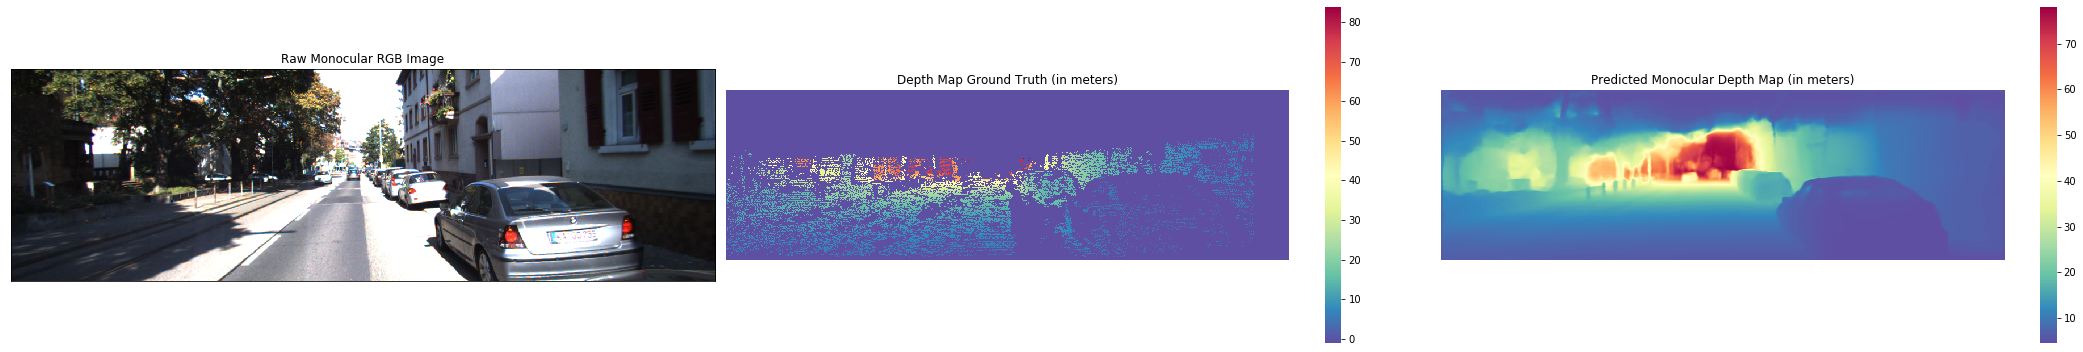

raw image shape: (370, 1226, 3)
depth map shape: (370, 1226)
predicted depth map shape: (370, 1226)


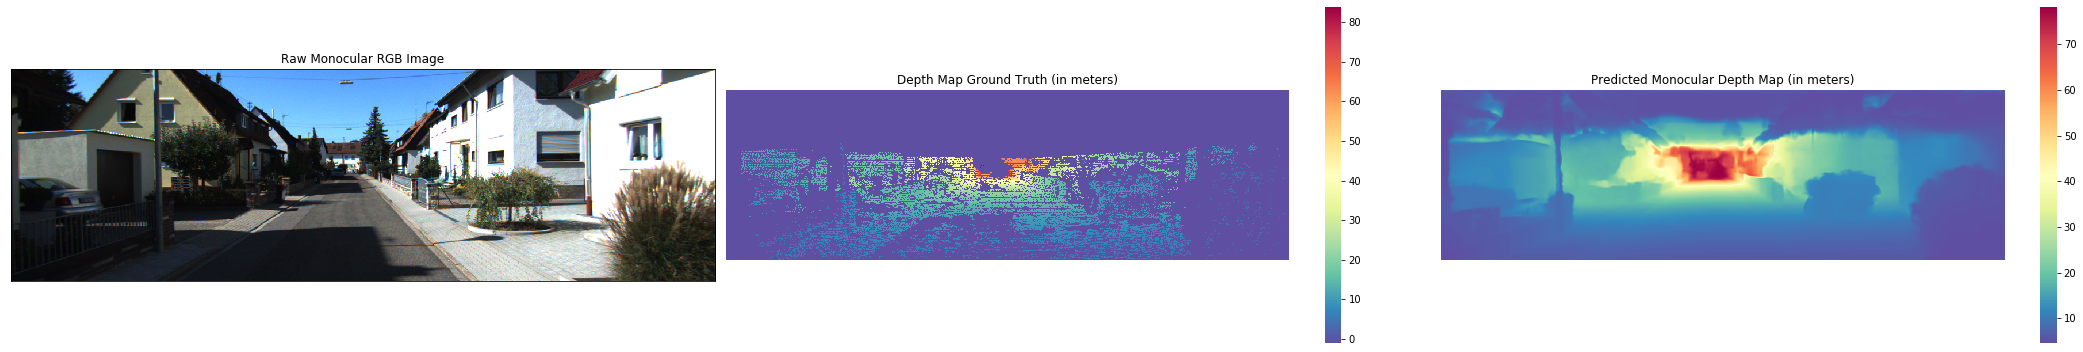

raw image shape: (370, 1226, 3)
depth map shape: (370, 1226)
predicted depth map shape: (370, 1226)


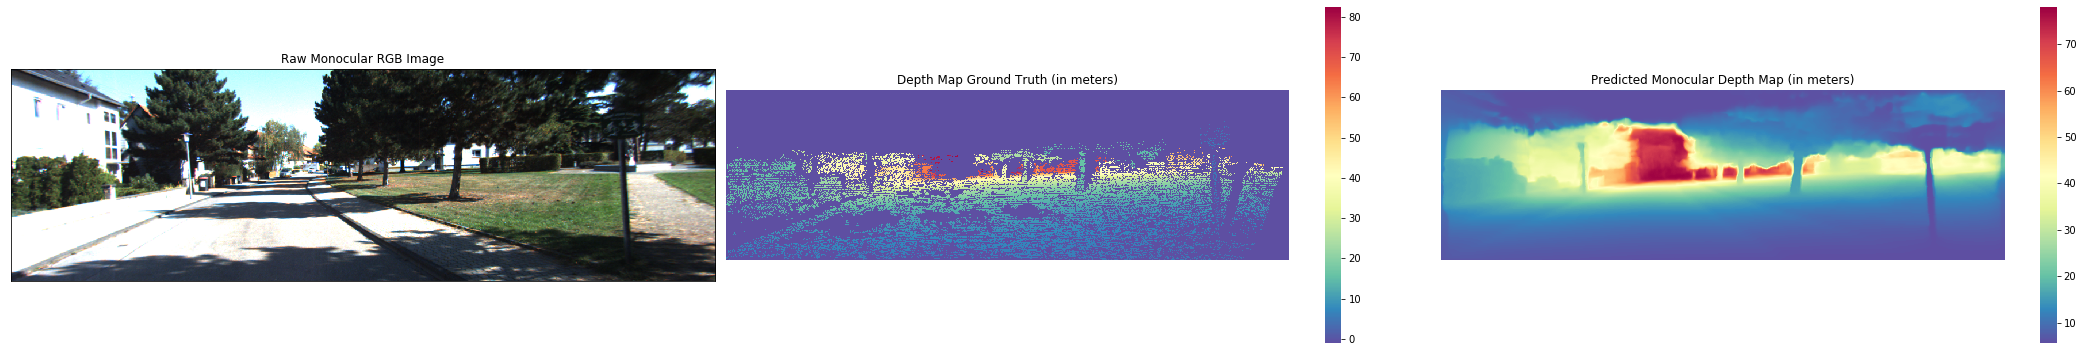

raw image shape: (370, 1226, 3)
depth map shape: (370, 1226)
predicted depth map shape: (370, 1226)


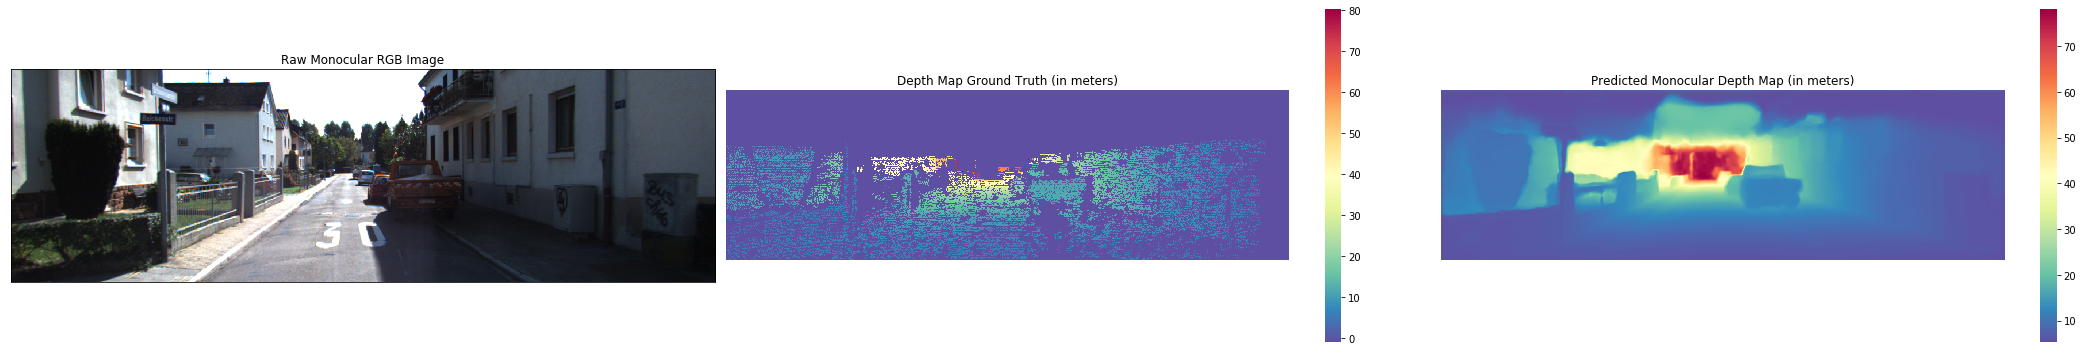

raw image shape: (376, 1241, 3)
depth map shape: (376, 1241)
predicted depth map shape: (376, 1241)


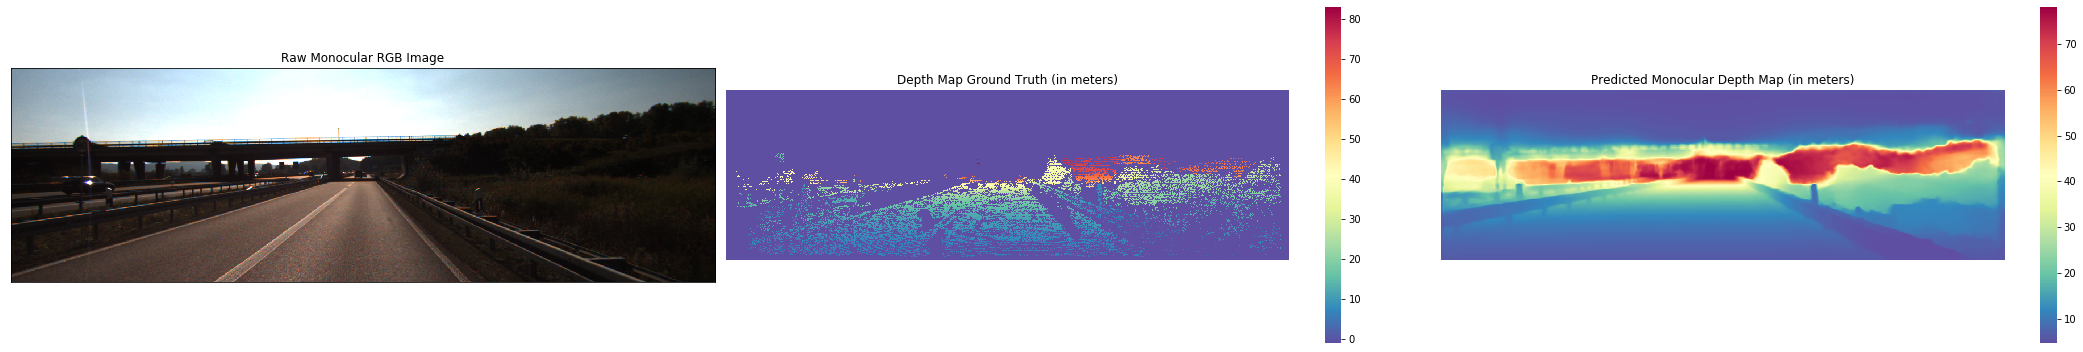

raw image shape: (376, 1241, 3)
depth map shape: (376, 1241)
predicted depth map shape: (376, 1241)


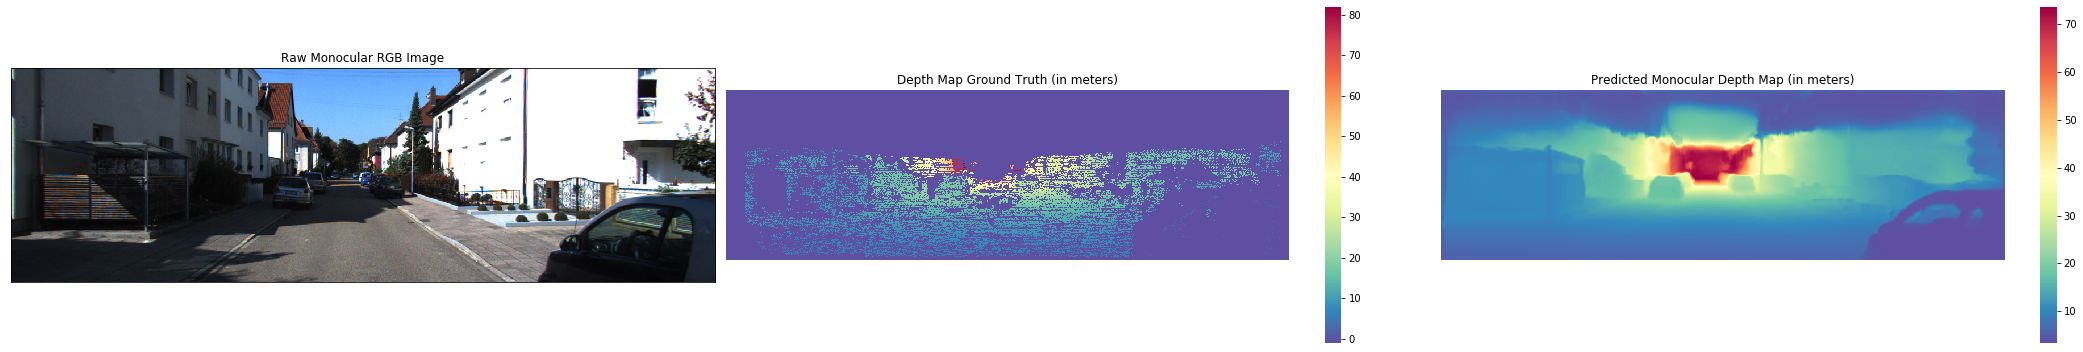

In [12]:
os.chdir('AdaBins')
try:
    AdaBins_prediction_viz(kitti_depthflattened_data_path, viz_num=5, should_print_size=True)
finally:
    os.chdir('..')